# Covid-19 Forecasting using an RNN

The goal of this notebook is very simple: Generate additional features from the Covid19-global-forecasting dataset and feed it into an RNN. The RNN will take as inputs:
*     number of cases for 13 days
*     number of fatalities for 13 days

as outputs:
*    number of cases for the 14th day
*    number of fatalities for the 14th day

* Update version 5: Submission pipeline fixed - score: 3.09681
* Update version 6: New RNN architecture with two separate branches for each output - score: 2.25901
* Update version 8: Add a post-processing step checking if the model's output is equal or greater the previous value - score: 2.29932
* Update version 9: Change the MSE losses to RMSLE - score: 1.43247
* Update version 11: Change the outputs' activation fucntions from linear to ReLU - score: 1.26594
* Update version 12: Use a 2-week period for predictions instead of 1. Replace the SimpleRNN layers with LSTM layers.

In [1]:
import numpy as np
import pandas as pd
#import geopandas as gpd
#from shapely.geometry import Point
import os
import tensorflow as tf
from tqdm import tqdm
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta

from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./torch_regression.py
./covid-19-rnn.ipynb
./covid-19-forecasting-with-an-rnn-2.ipynb
./best_model.h5
./covid_rf_model.ipynb
./RNN.ipynb
./submission/sub.csv
./proc_data/train.csv
./proc_data/test.csv
./proc_data/SampleSubmission.csv
./raw_data/Population density by countries.csv
./raw_data/train.csv
./raw_data/region_metadata.csv
./raw_data/SampleSubmission.csv
./raw_data/population_by_country_2020.csv
./.ipynb_checkpoints/RNN-checkpoint.ipynb
./.ipynb_checkpoints/covid-19-rnn-checkpoint.ipynb
./.ipynb_checkpoints/covid_rf_model-checkpoint.ipynb
./.ipynb_checkpoints/covid-19-forecasting-with-an-rnn-2-checkpoint.ipynb


In [2]:
train_df = pd.read_csv("./raw_data/train.csv")
train_df["Territory"] = [ter.replace("'","") for ter in train_df["Territory"]]

# Cast Date to datetime
train_df['Date'] = pd.to_datetime(train_df['Date'])

train_df.head()

,Territory X Date,target,cases,Territory,Date
0,Afghanistan X 1/22/20,0,0,Afghanistan,2020-01-22
1,Afghanistan X 1/23/20,0,0,Afghanistan,2020-01-23
2,Afghanistan X 1/24/20,0,0,Afghanistan,2020-01-24
3,Afghanistan X 1/25/20,0,0,Afghanistan,2020-01-25
4,Afghanistan X 1/26/20,0,0,Afghanistan,2020-01-26


I create a new dataframe where I will only store 6-day trends for each location with the resulting numbers on the 7th day. The time periods extracted do not overlap on purpose.

In [3]:
trend_df = pd.DataFrame(columns={"fatality_trend","expected_fatalities"})

In [4]:
#Just getting rid of the first days to have a multiple of 14
#Makes it easier to generate the sequences
train_df = train_df.query("Date>='2020-01-22'and Date<='2020-03-05'")
days_in_sequence = 14

with tqdm(total=len(list(train_df.Territory.unique()))) as pbar:
    for country in train_df.Territory.unique():
        for province in train_df.query("Territory=='"+country+"'"):
            province_df = train_df.query("Territory=='"+country+"'")
            for i in range(0, len(province_df), int(days_in_sequence/2)):
                if i + days_in_sequence <= len(province_df):
                    fatality_trend = [float(x) for x in province_df[i:i + days_in_sequence - 1].target.values]
                    expected_fatalities = float(province_df.iloc[i + days_in_sequence].target)
                                            
                    trend_df = trend_df.append({"fatality_trend":fatality_trend,
                                     "expected_fatalities":expected_fatalities},ignore_index=True)
        pbar.update(1)

100%|██████████| 209/209 [00:22<00:00,  9.31it/s]


Shuffling the dataframe to make sure we have a bit of everything in our training and validation set.

In [5]:
trend_df["input"] = [np.asarray([trends["fatality_trend"]]) for idx,trends in trend_df.iterrows()]

In [6]:
trend_df = shuffle(trend_df)
trend_df.head()

,fatality_trend,expected_fatalities,input
1723,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4408,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4590,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2863,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3953,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


Only keeping 200 sequences where the number of cases stays at 0, as there were way too many of these samples in our dataset.

In [6]:
i=0
y=0
temp_df = pd.DataFrame(columns={"fatality_trend","expected_fatalities","input"})
for idx,row in trend_df.iterrows():
    if sum(row.fatality_trend)>0:
        temp_df = temp_df.append(row)
    else:
        if i<2000:
            temp_df = temp_df.append(row)
            i+=1
trend_df = temp_df

In [7]:
trend_df[:20]

,expected_fatalities,fatality_trend,input
0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
6,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
8,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


Splitting my dataset - 90% for training and 10% for validation

In [8]:
sequence_length = 13
training_percentage = 0.9

In [9]:
training_item_count = int(len(trend_df) * training_percentage)
validation_item_count = len(trend_df) - int(len(trend_df) * training_percentage)
training_df = trend_df[:training_item_count]
validation_df = trend_df[training_item_count:]

In [10]:
X_train = np.asarray(np.reshape(np.asarray([np.asarray(x) for x in training_df["input"]]),(training_item_count,1,sequence_length))).astype(np.float32)

Y_fatalities_train = np.asarray([np.asarray(x) for x in training_df["expected_fatalities"]]).astype(np.float32)

In [11]:
X_test = np.asarray(np.reshape(np.asarray([np.asarray(x) for x in validation_df["input"]]),(validation_item_count,1,sequence_length))).astype(np.float32)

Y_fatalities_test = np.asarray([np.asarray(x) for x in validation_df["expected_fatalities"]]).astype(np.float32)

## Build the model

The model is very simple in terms of architecture. The only difference from what could traditionally be seen is that it has two outputs so we can have two different losses (one for the expected number of cases and for the expected number of fatalities).

In [12]:
input_layer = Input(shape=(1,sequence_length))
main_rnn_layer = layers.LSTM(256, return_sequences=True, recurrent_dropout=0.2)(input_layer)

rnn_f = layers.LSTM(128)(main_rnn_layer)

dense_f = layers.Dense(256)(rnn_f)
dropout_f = layers.Dropout(0.2)(dense_f)

fatalities = layers.Dense(1, activation="relu", name="fatalities")(dropout_f)
model = Model(input_layer, [fatalities])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 13)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 256)            276480    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
fatalities (Dense)           (None, 1)                 257       
Total params: 506,881
Trainable params: 506,881
Non-trainable params: 0
_______________________________________________________

In [13]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.7),
             EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model.compile(loss=[tf.keras.losses.MeanSquaredLogarithmicError()], optimizer='adam')

In [14]:
history = model.fit(X_train, [Y_fatalities_train], 
          epochs = 200, 
          batch_size = 64, 
          validation_data=(X_test,  [Y_fatalities_test]), 
          callbacks=callbacks)

Train on 1926 samples, validate on 214 samples
Epoch 1/200
1926/1926 [==============================] - 8s 4ms/sample - loss: 0.4627 - val_loss: 0.2198
Epoch 2/200
1926/1926 [==============================] - 1s 430us/sample - loss: 0.1846 - val_loss: 0.1054
Epoch 3/200
1926/1926 [==============================] - 1s 484us/sample - loss: 0.1411 - val_loss: 0.0517
Epoch 4/200
1926/1926 [==============================] - 1s 364us/sample - loss: 0.1222 - val_loss: 0.0421
Epoch 5/200
1920/1926 [============================>.] - ETA: 0s - loss: 0.0977
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
1926/1926 [==============================] - 1s 448us/sample - loss: 0.0974 - val_loss: 0.0970
Epoch 6/200
1792/1926 [==========================>...] - ETA: 0s - loss: 0.0872
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0004900000232737511.
1926/1926 [==============================] - 1s 370us/sample - loss: 0.0854 - val_loss: 0.0890
Epoch 7/200
1856/

## Performance during training

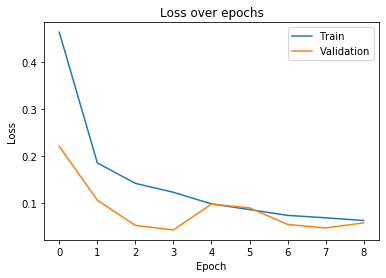

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

## Generate predictions using the model

We can quickly check the quality of the predictions... One thing is clear, there is room for improvement!

In [16]:
model.load_weights("best_model.h5")

In [17]:
predictions = model.predict(X_test)

In [18]:
X_test.shape

(214, 1, 13)

In [19]:
model.output_shape

(None, 1)

In [20]:
display_limit = 50
for inputs, pred_fatalities, exp_fatalities in zip(X_test, predictions[:display_limit], Y_fatalities_test[:display_limit]):
    print("================================================")
    print(inputs)
    print("Expected fatalities:", exp_fatalities, " Prediction:", pred_fatalities)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Expected fatalities: 0.0  Prediction: [0.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Expected fatalities: 0.0  Prediction: [0.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Expected fatalities: 0.0  Prediction: [0.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Expected fatalities: 0.0  Prediction: [0.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Expected fatalities: 0.0  Prediction: [0.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Expected fatalities: 0.0  Prediction: [0.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Expected fatalities: 0.0  Prediction: [0.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Expected fatalities: 0.0  Prediction: [0.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Expected fatalities: 0.0  Prediction: [0.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Expected fatalities: 0.0  Prediction: [0.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Expected fatalities: 0.0  Prediction: [0.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Expected fa

### Apply the model on this existing data

The following functions will be used to get the 6 previous days from a given date, predict the number of cases and fatalities, before iterating again. Therefore, it will use the prediction for the next day as part of the data for the one afterwards.

In [33]:
#Will retrieve the number of cases and fatalities for the past 6 days from the given date
def build_inputs_for_date(country, date, df):
    start_date = date - timedelta(days=13)
    end_date = date - timedelta(days=1)
    
    str_start_date = start_date.strftime("%Y-%m-%d")
    str_end_date = end_date.strftime("%Y-%m-%d")
    df = df.query("Territory=='"+country+"' "and" Date>='"+str_start_date+"' "and" Date<='"+str_end_date+"'")
    #print(np.asarray([df["cases"], df["target"]]).shape)
    input_data = np.reshape(np.asarray([df["target"]]),(1, sequence_length)).astype(np.float32)
    return input_data

In [34]:
#Take a dataframe in input, will do the predictions and return the dataframe with extra rows
#containing the predictions
def predict_for_region(country, df):
    begin_prediction = "2020-03-06"
    start_date = datetime.strptime(begin_prediction,"%Y-%m-%d")
    end_prediction = "2020-06-07"
    end_date = datetime.strptime(end_prediction,"%Y-%m-%d")
    
    date_list = [start_date + timedelta(days=x) for x in range((end_date-start_date).days+1)]
    for date in date_list:
        input_data = build_inputs_for_date(country, date, df)
        result = model.predict(np.array([input_data]))
        
        #just ensuring that the outputs is above 0
        # or higher than the previous counts
        #Get the absolute value for the number of cases
        
        result[0] = np.round(result[0])
        if result[0]<input_data[0][-1]:
            result[0]=np.array([[input_data[0][-1]]])
            
        df = df.append({"Territory":country, 
                        #"Province_State":province, 
                        "Date":date.strftime("%Y-%m-%d"),
                        "target":round(result[0][0][0])},ignore_index=True)
    return df

In [35]:
copy_df = train_df.loc[5:,:]
print(copy_df.shape)
with tqdm(total=len(list(copy_df.Territory.unique()))) as pbar:
    for country in copy_df.Territory.unique():
        #for province in copy_df.query("Territory=='"+country+"'"):
        copy_df = predict_for_region(country, copy_df)
        pbar.update(1)

  0%|          | 0/209 [00:00<?, ?it/s]

(9191, 5)


ValueError: cannot reshape array of size 9191 into shape (1,13)

In [133]:
copy_df.query("Territory=='France' and Date>'2020-03-10'")

,Territory X Date,target,cases,Territory,Date


In [30]:
test_df = pd.read_csv("./proc_data/test.csv")
test_df.head()

,Territory X Date,target,Territory,Date
0,Afghanistan X 3/6/20,0,Afghanistan,2020-03-06
1,Afghanistan X 3/7/20,0,Afghanistan,2020-03-07
2,Afghanistan X 3/8/20,0,Afghanistan,2020-03-08
3,Afghanistan X 3/9/20,0,Afghanistan,2020-03-09
4,Afghanistan X 3/10/20,0,Afghanistan,2020-03-10


Just need to do this little trick to extract the relevant date and the forecastId and add that to the submission file.

In [27]:
submission_df = pd.DataFrame(columns=["Territory X Date", "target"])
for idx, row in test_df.iterrows():
    #Had to remove single quotes because of countries like Cote D'Ivoire for example
    country_region = row.Territory.replace("'","").strip(" ")
    item = copy_df.query("Territory=='" + country_region + "' and Date=='" + row.Date + "'")
    submission_df = submission_df.append({"Territory X Date":row["Territory X Date"],
                                          "target":int(item.Fatalities.values[0])},
                                          ignore_index=True)

In [28]:
submission_df.sample(20)

,ForecastId,ConfirmedCases,Fatalities
6740,6741,1959,8
9579,9580,1254,11
11577,11578,834,9
5637,5638,551,1
2691,2692,67800,3122
3068,3069,18,0
4489,4490,540,4
12236,12237,1774,8
23,24,1781,10
3217,3218,1358,10


In [29]:
submission_df.to_csv("submission.csv",index=False)

### Of course, this notebook still requires a lot of work but I thought I would release a first version anyway, mainly to help anyone who could be working on a similar pipeline. I will try to update this notebook with an improved model itself and some charts to better understand our outputs in the following iterations.

### If you found this notebook helpful, please give it an upvote. It will be greatly appreciated!